In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c as C
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in", "font.size": 24})

In [36]:
def gaussian(x, center, FWHM, normalisation_coeffient = None):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    if normalisation_coeffient == None:
        normalisation_coeffient = 0.5/np.sum(np.abs(np.exp(exponent))) #1 /(sigma *(2*np.pi)**0.5)
        return normalisation_coeffient *np.exp(exponent), normalisation_coeffient
    else:
        return normalisation_coeffient *np.exp(exponent)

In [37]:
array_length = 200 #in pixels
pixel_pitch = 200 #in um
central_freq = 3.0 #in THz
FWHM_freq = 1.5 #in THz
theta = 60 #in arcminutes
signal_to_noise = 20 # maximum S:N

In [38]:
central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /C #periodicity of the fringes as it appears on the camera in m^-1
FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /C # in m^-1

print(1/central_wavenumber/(pixel_pitch*1e-6)) # effective wavelength in pixels


14.31476222096391


In [39]:
####### CREATE GAUSSIAN FREQUENCIES ###########

wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
freqs = C *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
amplitudes, normalisation_coeffient = gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)
#amplitudes = phase *amplitudes
intensity = np.fft.irfft(amplitudes, norm= "forward", n= array_length)

oversampled_wn = np.fft.rfftfreq(array_length *10, (pixel_pitch*1e-6))
oversampled_freqs = C *oversampled_wn /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
oversampled_amps = gaussian(oversampled_wn, central_wavenumber, FWHM_wavenumber, normalisation_coeffient= normalisation_coeffient)

displacement = np.arange(-(pixel_pitch*1e-3* array_length//2), (pixel_pitch*1e-3* array_length//2), pixel_pitch*1e-3) #in mm
#intensity = np.exp(-4 *np.log(2) *displacement**2 *35**-2) *(np.cos(2*np.pi*104.73*displacement*1e-3) +np.cos(2*np.pi*162.92*displacement*1e-3)) #overwrite internsity for 270GHz source. 9x 30GHz peak + 15x 30GHz harmonic + 35mm FWHM Gaussian Envelope due to spot size. 
#amplitudes = np.fft.rfft(intensity, norm= "forward") #overwrite amplitudes for 270GHz source


In [40]:
####### IFFT TO MAKE INTERFEROGRAMS ###########

vibration_intensity = np.fft.irfft(amplitudes, norm= "forward", n= array_length)

In [46]:
####### ADD READ NOISE ########

read_noise_sigma = 1/signal_to_noise # as a fraction of the interferogram peak signal. 
print(read_noise_sigma)

noise = np.random.normal(0, read_noise_sigma, (array_length))
noisy_intensity = vibration_intensity +noise
noisy_amps = np.fft.rfft(noisy_intensity, norm= "forward")


0.05


In [42]:
########## SHIFT ALL INTERFEROGRAMS AROUND 0 ############

intensity = np.fft.fftshift(intensity)
vibration_intensity = np.fft.fftshift(vibration_intensity)
noisy_intensity = np.fft.fftshift(noisy_intensity)


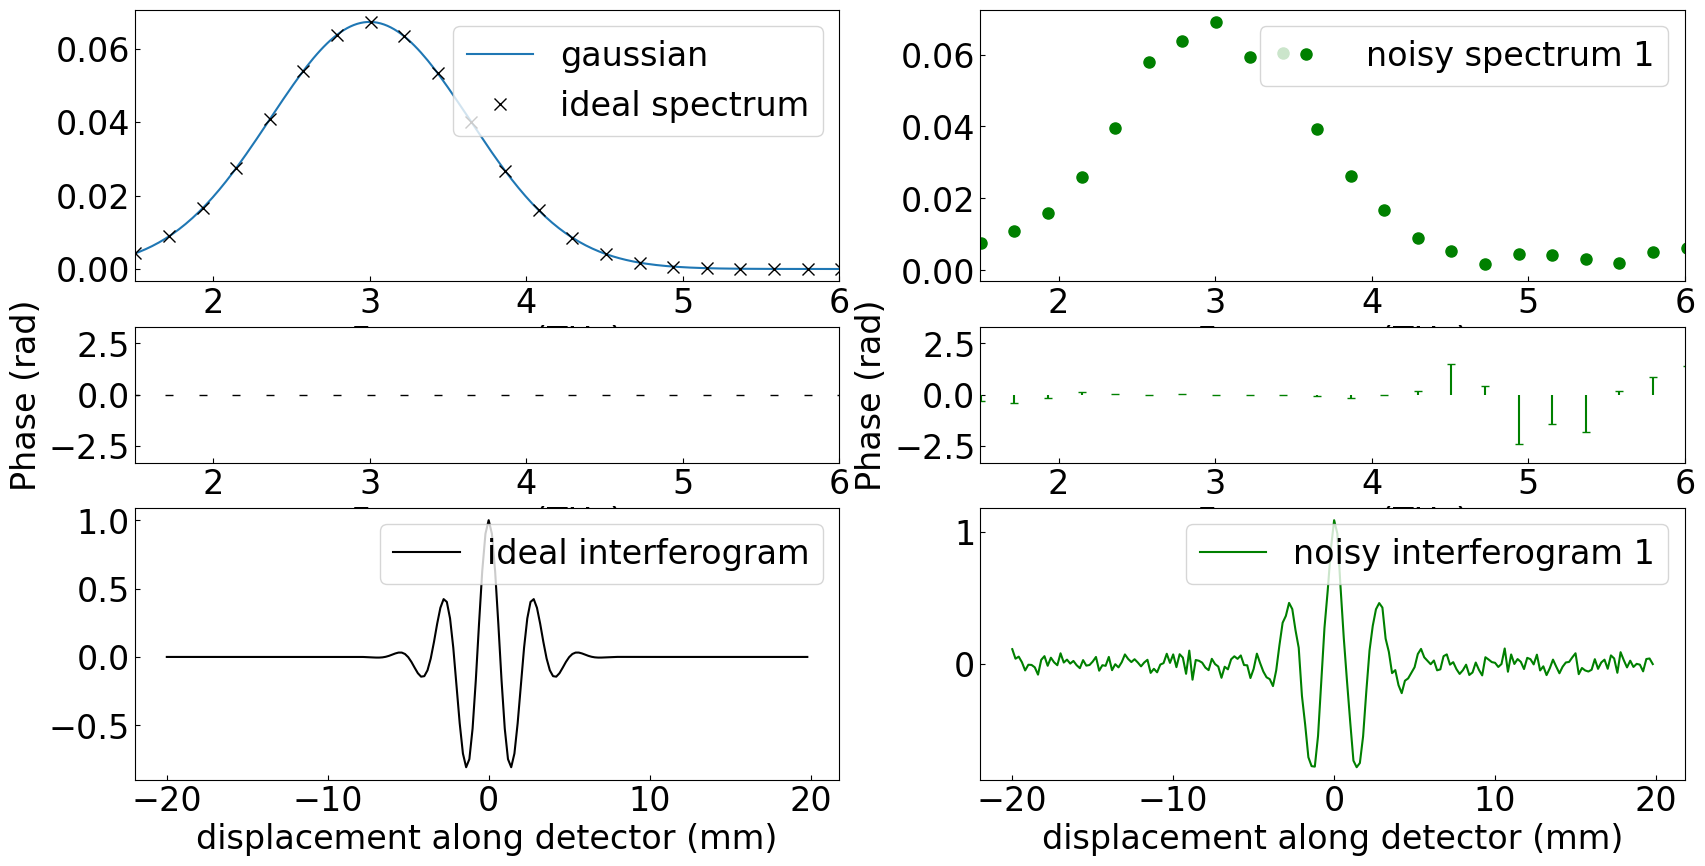

In [43]:
########## MEGACHONKER GRAPH ##############

mosaic = [["spec 1", "spec 2"],
          ["phase 1", "phase 2"],
          ["ifft 1", "ifft 2"]]

fig, axs = plt.subplot_mosaic(mosaic, figsize= (20,10), height_ratios= (1, 0.5, 1))

axs["spec 1"].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs["spec 1"].plot(freqs, np.abs(amplitudes), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "ideal spectrum")
axs["spec 1"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 1"].legend(loc ="upper right")

axs["phase 1"].stem(freqs, np.angle(amplitudes), markerfmt ="k_", basefmt= "None", linefmt= "k")
axs["phase 1"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 1"].plot(displacement, intensity, color= "k", label= "ideal interferogram")
axs["ifft 1"].set(xlabel= "displacement along detector (mm)")
axs["ifft 1"].legend(loc ="upper right")

axs["spec 2"].plot(freqs, np.abs(noisy_amps), linestyle= "None", marker= "o", markersize= 8, color= "green", alpha= 1, label= "noisy spectrum 1")
axs["spec 2"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 2"].legend(loc ="upper right")

axs["phase 2"].stem(freqs, np.angle(noisy_amps), markerfmt ="g_", basefmt= "None", linefmt= "g")
axs["phase 2"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 2"].plot(displacement, noisy_intensity, color= "green", alpha= 1, label= "noisy interferogram 1")
axs["ifft 2"].set(xlabel= "displacement along detector (mm)")
axs["ifft 2"].legend(loc ="upper right")

plt.show()

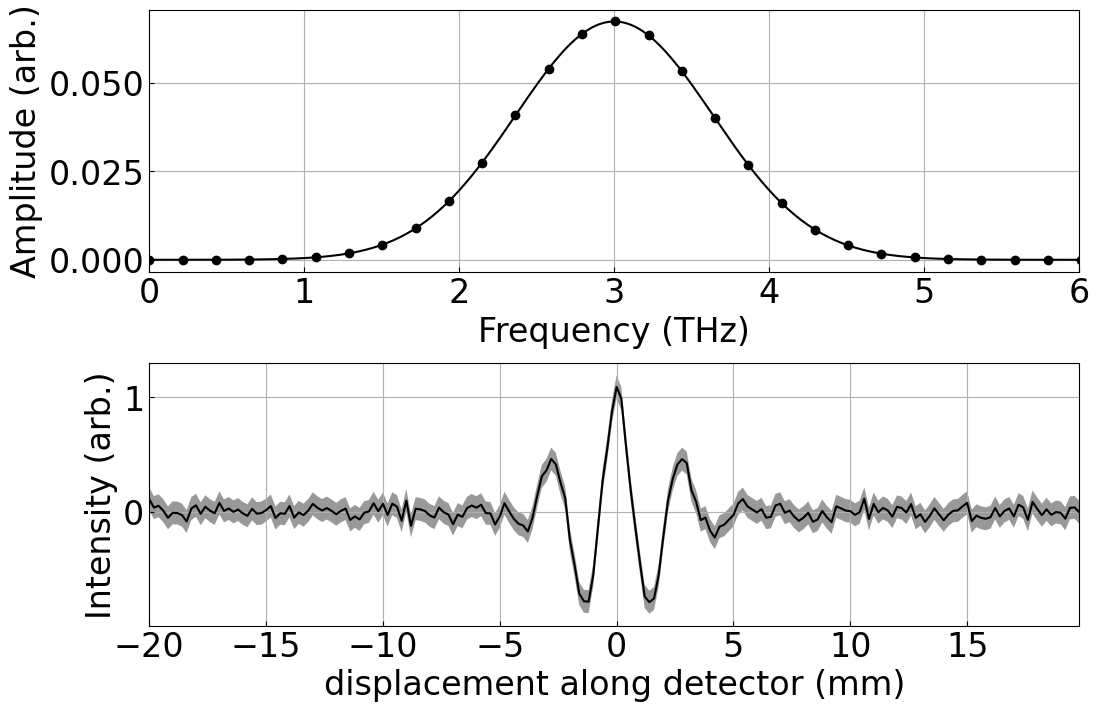

In [44]:
fig, axs = plt.subplots(2,1, figsize= (12,8), gridspec_kw= {"hspace": 0.35})

axs[0].plot(oversampled_freqs, np.abs(oversampled_amps), color= "k")
axs[0].plot(freqs, np.abs(amplitudes), linestyle= "None", marker= "o", markersize= 6, color= "k")
axs[0].set(xlabel= "Frequency (THz)", ylabel= "Amplitude (arb.)", xlim= (0, 6.0))
axs[0].grid()

axs[1].plot(displacement, noisy_intensity, color= "k", label= "interferogram")
axs[1].fill_between(displacement, noisy_intensity- 2*read_noise_sigma, noisy_intensity+ 2*read_noise_sigma, facecolor= "gray", alpha= 0.8, label= "± std")
axs[1].set(xlabel= "displacement along detector (mm)" , ylabel= "Intensity (arb.)", xlim= (displacement.min(), displacement.max()))
axs[1].grid()

plt.savefig(r"C:\Users\rcr73298\Documents\THz-Compressed-Sensing\graphs\example_simulated_spectrum")
plt.show()

In [45]:
########### SAVE AN INTERFEROGRAM FOR TESTING #############

if np.any(uncertainty <= 1e-10): uncertainty = np.ones_like(uncertainty)

to_save = np.array([averaged_intensity, uncertainty]).T
#np.savetxt("data\\1dmockanderrors22.csv", to_save, delimiter=",")

NameError: name 'uncertainty' is not defined

In [ ]:
def generate_interferogram(array_length, pixel_pitch, central_freq, FWHM_freq, theta, number_of_averages= 30, vibration_uncertainty= 0, read_noise_sigma= 0):
    
    central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /C #periodicity of the fringes as it appears on the camera in m^-1
    FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /C # in m^-1

    wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
    freqs = C *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
    amplitudes, normalisation_coeffient = gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)

    temporal_sigma = vibration_uncertainty*1e-3 *2*np.sin(np.deg2rad(theta/60)) /C # convert to s.
    noise = np.random.normal(0, temporal_sigma, number_of_averages)

    vibration_amps = np.repeat(amplitudes[None, :], number_of_averages, axis= 0)
    vibration_amps = (vibration_amps *np.exp(1j *freqs[None, :]*1e12 *noise[:, None]))

    vibration_intensity = np.fft.irfft(vibration_amps, norm= "forward", axis= 1)

    noise = np.random.normal(0, read_noise_sigma, (number_of_averages, array_length))
    noisy_intensity = vibration_intensity +noise

    uncertainty = np.std(noisy_intensity, axis= 0)
    interferogram = np.mean(noisy_intensity, axis= 0)

    interferogram = np.fft.fftshift(interferogram)
    uncertainty = np.fft.fftshift(uncertainty)
    if np.all(uncertainty == 0): uncertainty = np.ones_like(uncertainty)

    return np.array([interferogram, uncertainty]).T

######### SAVE MANY INTERFEROGRAMS FOR TRAINING #########

array_length = 200 #in pixels
pixel_pitch = 200 #in um
central_freqs = np.linspace(2, 4, 30) #[0.1,0.2,0.5,1,2,5,10]
FWHM_freqs = np.linspace(0.5, 2, 30) #[0.1,0.2,0.5,1,2,5,10]
theta = 60
read_noise = 0.2

n = 0
for central_freq in central_freqs:
    for FWHM_freq in FWHM_freqs:
        #np.savetxt("data\\training_set6\\interferogram_{0:d}.csv".format(n),
        #           generate_interferogram(array_length, pixel_pitch, central_freq, FWHM_freq, theta, read_noise_sigma= read_noise),
        #           delimiter=",")
        n += 1